<a href="https://www.kaggle.com/code/shivamshinde123/image-generation-using-probabilistic-pca?scriptVersionId=227307809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="
    background-color: green;
    color: white;
    padding: 30px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h1>Image Generation Using Probabilistic Principal Component Analysis (p-PCA)</h1>
</div>

<div>
    <h2>Working of Probabilistic Principal Component Analysis (p-PCA)</h2>
    <p style="font-size:20px;"> p-PCA posits that every observed example x (dimension - m) is generated from a latent feature vector z (dimension - d, d < m), and latent features z can be sampled from a multivariate gaussian distribution with zero mean and identity covariance.</p>
    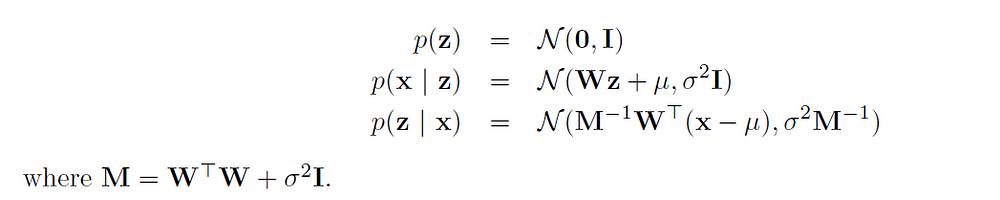
    <p style="font-size:20px;">The parameters of p-PCA are the matrix W (dimension - m x d) that projects the latent feature vector into the observable space, the mean mu (dimension - m) and the variance sigma (dimension - 1). The p-PCA has a closed form solution. For a dataset containing n examples (where each example x has dimension m) whose mean is mu and who covariance is S,</p>
    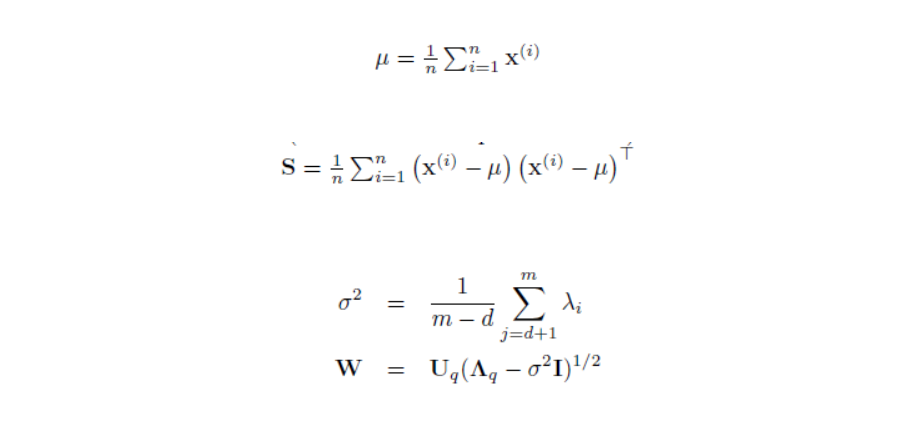
    <p style="font-size:20px;">where U_q contains the first d principal eigenvectors of S (i.e., the eigenvectors corresponding to the d eigenvalues with largest magnitude), A_q is a diagonal matrix containing the d largest-magnitude eigenvalues. After estimating the parameters of Probabilistic Principal Component Analysis (PPCA), we can generate new data points by randomly sampling values from a standard normal distribution to create a latent variable vector z. This vector z is then transformed using the learned model parameters.</p>
    <p style="font-size:20px;">By applying this transformation to the sampled z vector, we obtain a new data point x, which is a randomly generated observation. If the original x values represent images, this process allows us to generate new images by sampling z values from the standard normal distribution and passing them through the learned p-PCA model.</p>
</div>
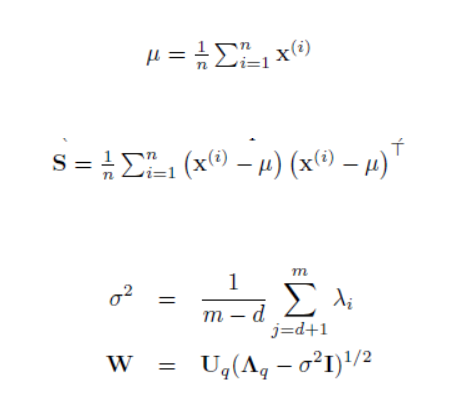
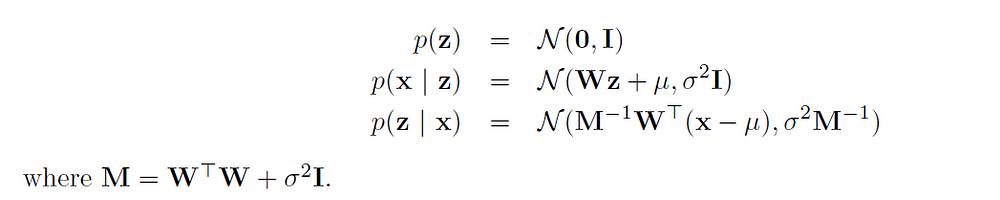
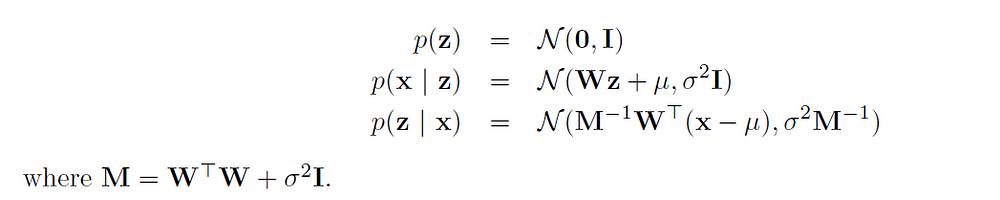
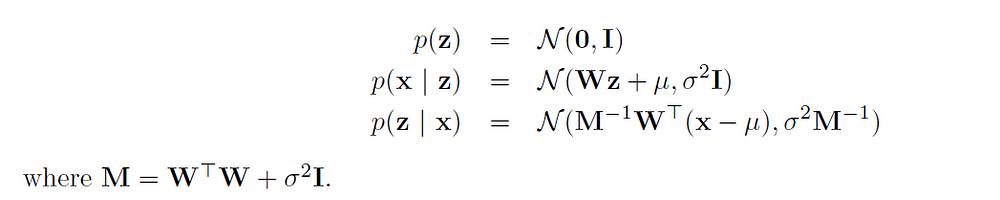

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Import Required Packages</h3>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Loading the Data</h3>
</div>

In [2]:
# load the data
train_data = np.load("/kaggle/input/greyscale-face-image-dataset/eigenfaces.npy")

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Checking the dataset Images</h3>
</div>

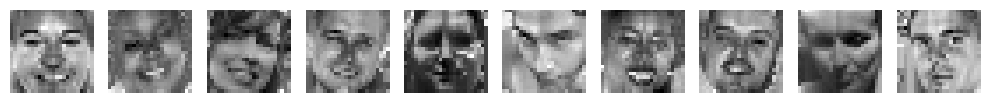

In [3]:
# Checking how the images look
images = train_data[np.random.choice(train_data.shape[0], 10, replace=False)]


# Create a 10x10 grid for the collage
fig, axes = plt.subplots(1, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(24, 24), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Function to calculate eigen values and eigen vectors</h3>
</div>

In [4]:
def get_eigenvalues_and_eigenvectors(input):

    # compute mean of the input
    mean = np.mean(input, axis=0)

    # compute the covariance matrix
    covariance_matrix = np.cov(input, rowvar=False, bias=True)

    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    return eigenvalues, eigenvectors

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Function to calculate highest d eigen values and eigen vectors</h3>
</div>

In [5]:
def get_highest_d_eigens(eigenvalues, eigenvectors, d):

    # create a dictionary to store the index of each eigenvalue
    evalue_index = {value: index for index, value in enumerate(eigenvalues)}

    # sort the eigenvalues in descending order
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)

    # get the highest d eigenvalues
    highest_d_eigenvalues = sorted_eigenvalues[:d]

    # get the indices of the highest d eigenvalues
    highest_d_eigenvalue_indices = [evalue_index[value] for value in highest_d_eigenvalues]

    # get the eigenvectors corresponding to the highest d eigenvalues
    highest_d_eigenvectors = eigenvectors[:, highest_d_eigenvalue_indices]

    # remaining eigenvalues
    remaining_eigenvalues = sorted_eigenvalues[d:]

    return highest_d_eigenvalues, highest_d_eigenvectors, remaining_eigenvalues

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Function to calculate p-PCA parameters</h3>
</div>

In [6]:
def get_ppca_parameters(input, d):

    # compute the mean of the input
    mean = np.mean(input, axis=0)

    # computing the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(input)

    # get the highest d eigenvalues and eigenvectors
    highest_d_eigenvalues, highest_d_eigenvectors, remaining_eigenvalues = get_highest_d_eigens(eigenvalues, eigenvectors, d)

    # compute the noise variance of the remaining eigenvalues
    variance = np.mean(remaining_eigenvalues)

    # compute the weight matrix
    highest_d_eigenvectors_diag = np.diag(highest_d_eigenvalues)
    weight_matrix = np.dot(highest_d_eigenvectors, np.sqrt(highest_d_eigenvectors_diag - variance))

    return mean, weight_matrix, variance

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Function to generate random image using d dimensional latent vector</h3>
</div>

In [7]:
def generate_random_image(train_data, d):
    
    # get the parameters of the PPCA model
    mean, weight, variance = get_ppca_parameters(train_data, d)

    # Get the random latent variable z from the standard normal distribution
    z = np.random.normal(0, 1, d)

    # construct image from the latent variable z
    x = mean + weight @ z

    # checking if the array x is complex
    if np.iscomplexobj(x):
        x = np.real(x)

    return x

<div>
    <p style="font-size:20px;">We have trained the p-PCA model on the human face images. Here are the 100 generated images generated using the trained p-PCA model:</p>
</div>

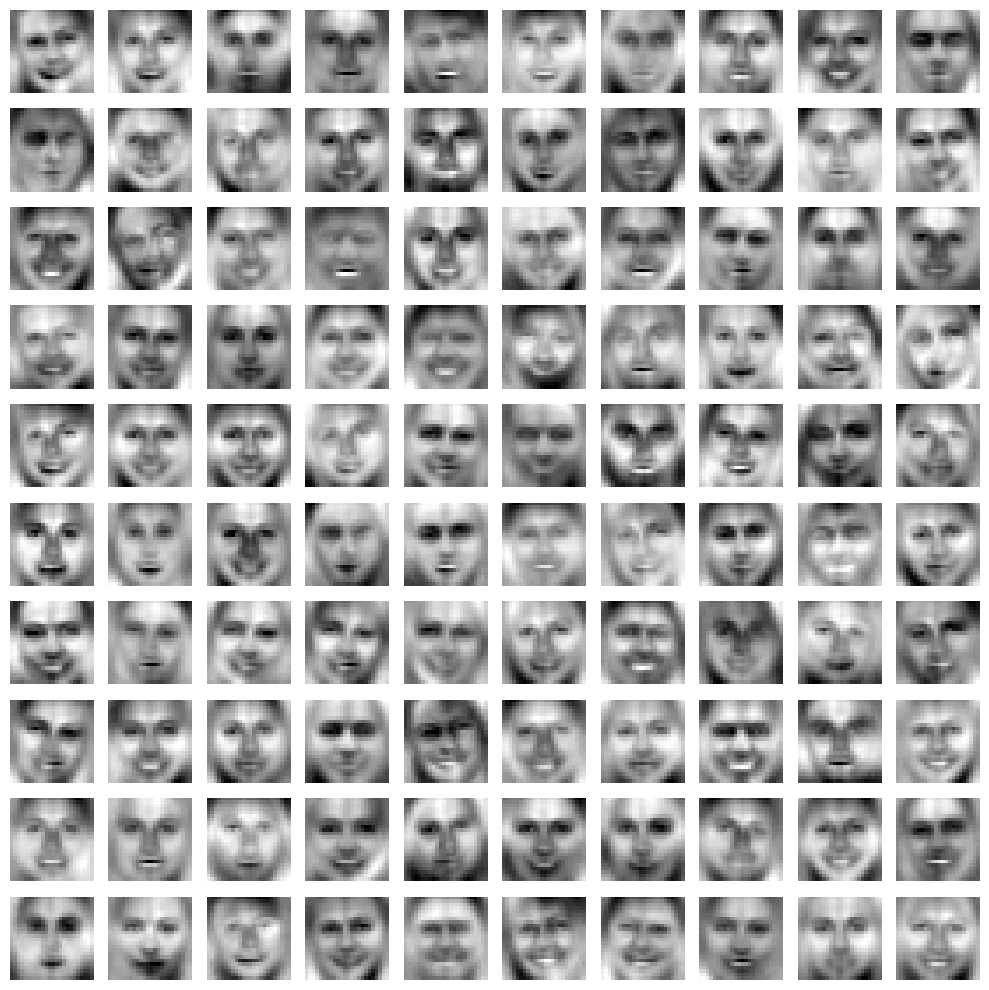

In [8]:
generated_images = list()
num_images = 100
latent_dim = 16
for i in range(num_images):
    x = generate_random_image(train_data, latent_dim)
    generated_images.append(x)

# Reshape each row into a 24x24 image
generated_images = np.array(generated_images)
generated_images = generated_images.reshape((num_images, 24, 24))

# Create a 10x10 grid for the collage
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
if not os.path.exists(os.path.join("/kaggle/working/", "Images")):
    os.makedirs(os.path.join("/kaggle/working/", "Images"))
    
plt.savefig(os.path.join("/kaggle/working/", "Images", "generated_images.png"))
plt.show()

<p style="font-size:20px;">The images generated are quite blurry. The reason is that the p-PCA model is linear and hence quite simple.</p>

<div style="
    background-color: pink;
    color: black;
    padding: 15px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Checking how the image change when some of the latent vector values are changed</h3>
</div>

<p style="font-size:20px;">We could also perturb one of the latent dimensions by small amount and see how the images changes. We have created 5 × 10 collage of image reconstructions from the perturbed latent vectors (i.e., 5 different latent dimensions, and 10 different linearly-spaced perturbations each).</p>

In [9]:
def perturb_latent_vector(train_data, d):
    
    # getting two images and using only one of them - because np.cov function needs atleast two inputs to work
    images = train_data[np.random.choice(train_data.shape[0], 2, replace=False)]

    print("Original Image")
    plt.imshow(images[0].reshape(24, 24), cmap='gray')    
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.savefig(os.path.join('Images', f"original_image.png"))
    plt.show()
                                    
    # get the parameters of the PPCA model
    mean, weight, variance = get_ppca_parameters(images, d)

    # calculate M
    M = np.dot(weight.T, weight) + variance * np.eye(weight.shape[1])

    # calculate latent z
    z_hat = np.linalg.solve(M, weight.T @ (images - mean).T)
    z_hat = z_hat[:, 0].reshape(-1, 1)  

    # Getting the random dimension between 0 and d-1
    random_dimension = np.random.randint(0, d)

    # getting 10 equispaced numbers between -0.05 and 0.05
    perturbations = np.linspace(-5, 5, 10)

    # create a list to store the generated images
    generated_images = list()
    for i in range(random_dimension):
        for j in range(len(perturbations)):
            z_hat[i] = z_hat[i] + perturbations[j]
            reconstructed_image = (mean.reshape(-1, 1) + weight @ z_hat).T

            # checking if the array z is complex
            if np.iscomplexobj(reconstructed_image):
                reconstructed_image = np.real(reconstructed_image)

            generated_images.append(reconstructed_image)

    # reshaping each row in 24x24
    generated_images = np.array(generated_images)
    generated_images = generated_images.reshape((random_dimension * 10, 24, 24))

    print("Images generated after perturbing latent vector values")
    # create a 10x10 grid for the collage
    fig, axes = plt.subplots(5, 10, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    if not os.path.exists(os.path.join("/kaggle/working/", "Images")):
        os.makedirs(os.path.join("/kaggle/working/", "Images"))
    plt.savefig(os.path.join("/kaggle/working/", "Images", f"perturbed_images.png"))
    plt.show()

Original Image


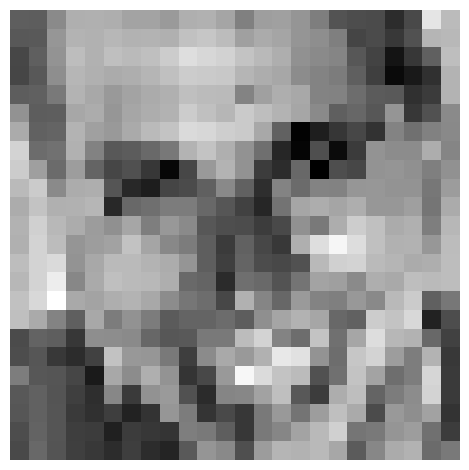

Images generated after perturbing latent vector values


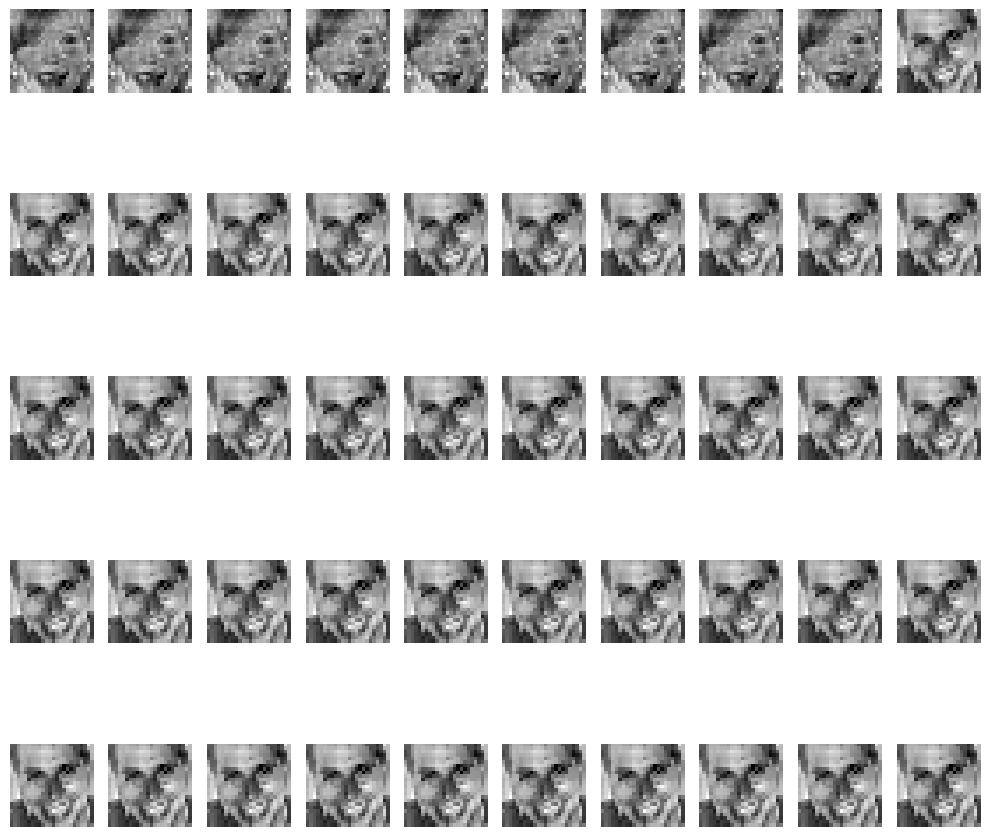

In [10]:
perturb_latent_vector(train_data, 16)

<p style="font-size:20px;">Observe how the image is transforming when we change 5 differnt latent variable dimensions with 10 different values.</p>